# Sistema de predicción de ventas

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.


### 0. Importar liberías

In [21]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import warnings

import pickle 

### 1. Carga de información

In [6]:
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(url)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


### 2. Construir y analizar la serie temporal

In [7]:
df_copy = df.copy()
df_copy["date"] = pd.to_datetime(df_copy["date"]).dt.date
df_copy = df_copy.set_index("date")
ts = df_copy["sales"]
ts.head()


date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

El tensor de la serie temporal corresponde a una estructura unidimensional, ya que se usa `date` como índice temporal y el valor de las ventas como asociado.

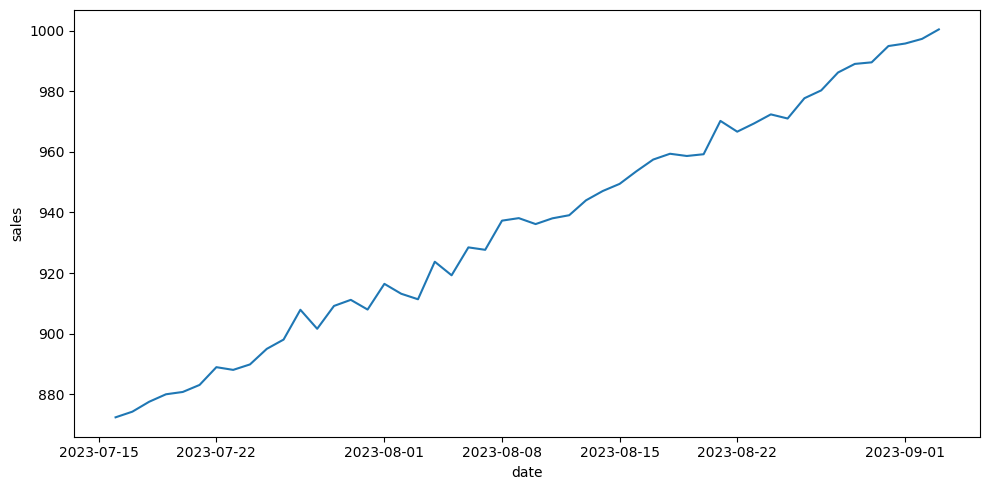

In [8]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts.tail(50))

plt.tight_layout()

plt.show()

In [9]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

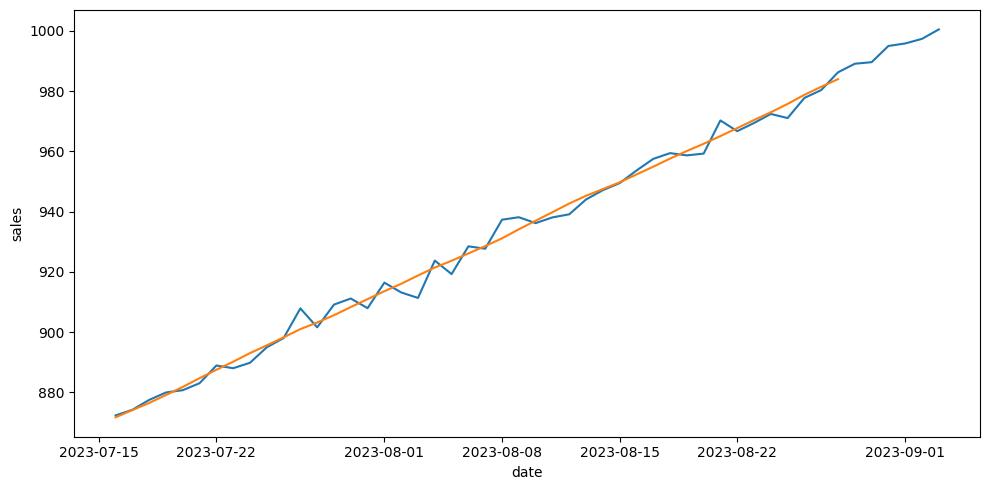

In [10]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts.tail(50))
sns.lineplot(data = trend.tail(50))

plt.tight_layout()

plt.show()

La tendencia es positiva a lo largo del gráfico

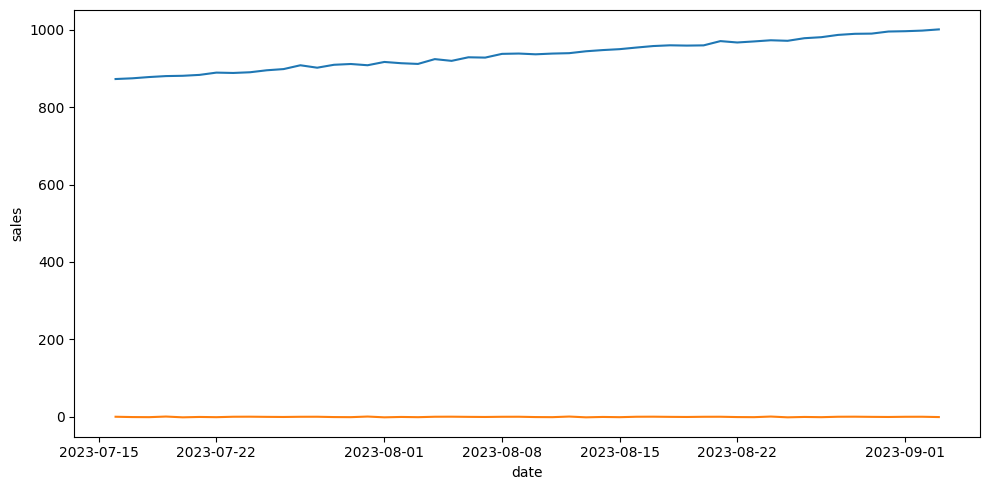

In [11]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts.tail(50))
sns.lineplot(data = seasonal.tail(50))

plt.tight_layout()

plt.show()

In [12]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

El p-value es mayor a 0.05 por lo que esta serie como no estacionaria y que los valores cambian con el tiempo

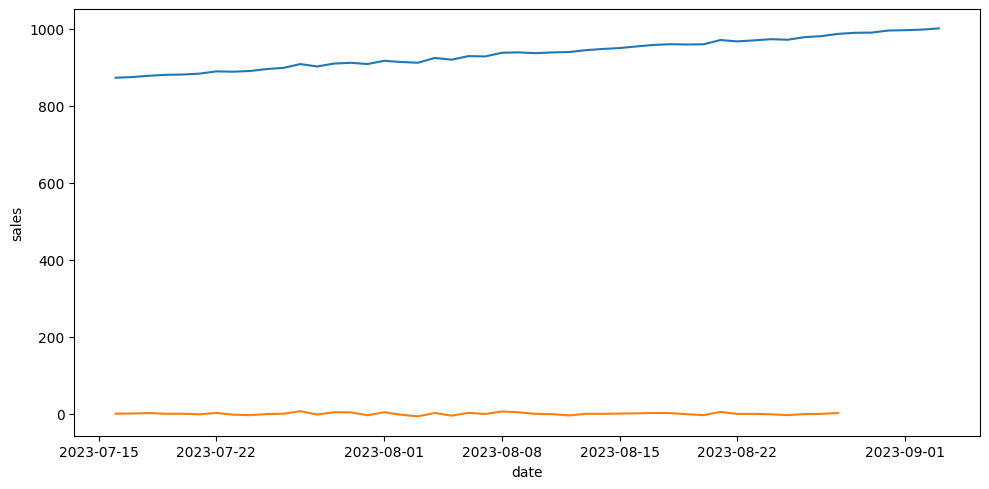

In [13]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts.tail(50))
sns.lineplot(data = residual.tail(50))

plt.tight_layout()

plt.show()

Hay variabilidad baja y los residuos estan cerca del 0, por lo que no parece haber ruido notorio.

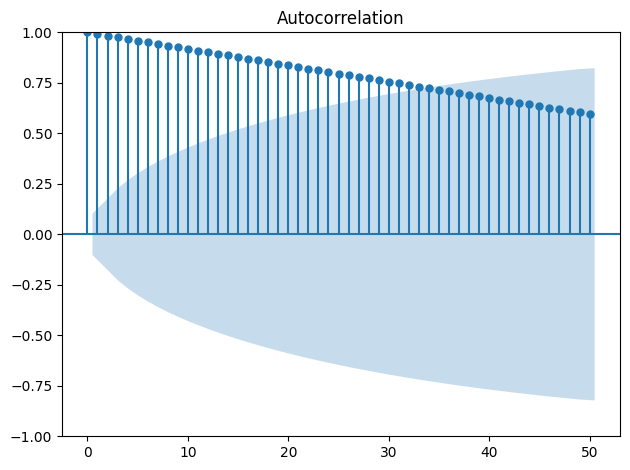

In [14]:
plot_acf(ts, lags=50)

plt.tight_layout()

plt.show()

El gráfico va cayendo poco a poco por lo que que el presente depende de muchos valores pasados y se confirma que la serie no es estacionaria.

### 3. Entrenar un ARIMA

In [15]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Por problemas de compatibilidad y versiones usare Sarimax para entrenar un modelo

In [26]:
warnings.filterwarnings("ignore") 

# p = valores pasados del modelo / d = cuantas veces se revisa para ahcerlo estacionario / q = errores pasados 
def auto_arima_manual(ts, p_range=range(0,3), d_range=range(0,2), q_range=range(0,3), P_range=range(0,2), D_range=range(0,2), Q_range=range(0,2), s=12):
    
    best_aic = float("inf") ## Debe ser infinito ya que se conseguira numeros menores progresivamente.
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    for p,d,q in itertools.product(p_range,d_range,q_range):
        for P,D,Q in itertools.product(P_range,D_range,Q_range):
            # Prueba a realizar el modelo si hhay error se lo salta
            try:
                model = SARIMAX(ts,
                                order=(p,d,q),
                                seasonal_order=(P,D,Q,s),
                                ## Permite ajustes aun si los parametros no cumplen restricciones estrictas
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                
                if fit_model.aic < best_aic:
                    best_aic = fit_model.aic
                    best_order = (p,d,q)
                    best_seasonal_order = (P,D,Q,s)
                    best_model = fit_model
            except:
                continue
    
    print(f"Mejor AIC: {best_aic}")
    print(f"Mejor orden ARIMA: {best_order}")
    print(f"Mejor orden estacional: {best_seasonal_order}")
    return best_model




In [23]:
best_model = auto_arima_manual(ts_stationary, s=12)


Mejor AIC: 1735.1344693770498
Mejor orden ARIMA: (1, 0, 2)
Mejor orden estacional: (0, 1, 1, 12)


In [24]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                sales   No. Observations:                  365
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -862.567
Date:                              Sun, 17 Aug 2025   AIC                           1735.134
Time:                                      21:19:01   BIC                           1754.250
Sample:                                  09-04-2022   HQIC                          1742.753
                                       - 09-03-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6813      0.253      2.689      0.007       0.185       1.178
ma.L1         -1.6823      0.237     -7.095      0.000      -2.147      -1.218
ma.L2          0.7039      0.222      3.167      0.002       0.268       1.139
ma.S.L12      -0.9447      0.048    -19.767      0.000      -1.038      -0.851
sigma2         9.0829      0.730     12.441      0.000       7.652      10.514
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.78   Prob(JB):                         0.93
Heteroskedasticity (H):               1.00   Skew:                             0.05
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4. Predecir con el conjunto de test

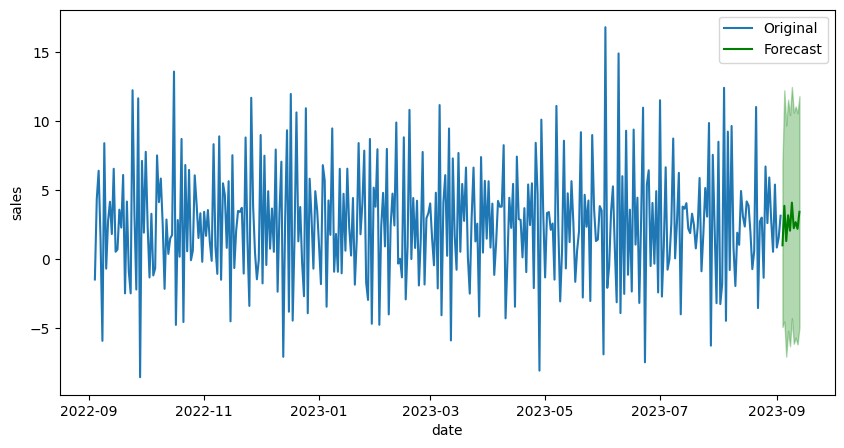

In [36]:
forecast = best_model.get_forecast(steps=10)
pred = forecast.predicted_mean  # Valores predichos
conf_int = forecast.conf_int()  # Intervalos de confianza 

plt.figure(figsize=(10,5))
sns.lineplot(data=ts_stationary, label='Original')
sns.lineplot(data=pred, label='Forecast', color='green')  

plt.fill_between(pred.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.3)

plt.legend()
plt.show()

### 5. Guardar el modelo

In [37]:
with open("../models/modelo_talternativo.pkl", "wb") as f:
    pickle.dump(best_model, f)